In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

import sys
sys.path.append('/home/rustam/hyperspecter_segmentation/makitorch')
sys.path.append('/home/rustam/hyperspecter_segmentation/')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import cv2
from hsi_dataset_api import HsiDataset
from makitorch.dataloaders.HsiDataloader import HsiDataloader

import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
import torchvision.transforms.functional as TF
from torchvision import utils
import cv2
from Losses import FocalLoss
import matplotlib.pyplot as plt

import seaborn as sns
import json

from my_super_attention_net_parts_diff_window_size_opt_change_lr_dyn_new_augs import *

In [2]:
net = MySuperNetLittleInput(17, 17)
net.eval()
with torch.no_grad():
    _ = net(torch.randn(1, 17, 128, 128))
net.train()

MySuperNetLittleInput(
  (backbone): Sequential(
    (0): Conv2d(17, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (cam_module): CAM_Module(
    (softmax): Softmax(dim=-1)
  )
  (pam_module): PAM_Module(
    (query_conv): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(8,

In [3]:
import glob
w_sorted = sorted(glob.glob('pytorch_li_logs/rerun=1/(run=2)Attention_module_test_cut_window=(128, 128)_change_lr_dyn_arch_200ep_PCA_RustamPreprocess(k=1)_CE_cosine(t_0=2,t_mul=1)_arch_type=MySuperNetLittleInput_batch_size=4_lr=0.001/*'), 
       key=lambda x: -float(x.split('/')[-1].split('-')[-1][9:13])
)

pick_best_one = w_sorted[1]
w_sorted

['pytorch_li_logs/rerun=1/(run=2)Attention_module_test_cut_window=(128, 128)_change_lr_dyn_arch_200ep_PCA_RustamPreprocess(k=1)_CE_cosine(t_0=2,t_mul=1)_arch_type=MySuperNetLittleInput_batch_size=4_lr=0.001/model-epoch=164-mean_iou=0.56.ckpt',
 'pytorch_li_logs/rerun=1/(run=2)Attention_module_test_cut_window=(128, 128)_change_lr_dyn_arch_200ep_PCA_RustamPreprocess(k=1)_CE_cosine(t_0=2,t_mul=1)_arch_type=MySuperNetLittleInput_batch_size=4_lr=0.001/model-epoch=169-mean_iou=0.55.ckpt',
 'pytorch_li_logs/rerun=1/(run=2)Attention_module_test_cut_window=(128, 128)_change_lr_dyn_arch_200ep_PCA_RustamPreprocess(k=1)_CE_cosine(t_0=2,t_mul=1)_arch_type=MySuperNetLittleInput_batch_size=4_lr=0.001/model-epoch=199-mean_iou=0.55.ckpt',
 'pytorch_li_logs/rerun=1/(run=2)Attention_module_test_cut_window=(128, 128)_change_lr_dyn_arch_200ep_PCA_RustamPreprocess(k=1)_CE_cosine(t_0=2,t_mul=1)_arch_type=MySuperNetLittleInput_batch_size=4_lr=0.001/model-epoch=189-mean_iou=0.54.ckpt',
 'pytorch_li_logs/rerun=

In [4]:
model = NnModel.load_from_checkpoint(
    pick_best_one, 
    model=net, loss=nn.CrossEntropyLoss()
)

In [5]:
net = model.model
net.eval()

MySuperNetLittleInput(
  (backbone): Sequential(
    (0): Conv2d(17, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (cam_module): CAM_Module(
    (softmax): Softmax(dim=-1)
  )
  (pam_module): PAM_Module(
    (query_conv): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(8,

In [6]:
test_indices = np.load(f'{PREFIX_INFO_PATH}/kfold0_indx_test.npy')
# Test
dataset_creator_test = DatasetCreator(
    PATH_DATA, preprocessing=preprocessing, 
    indices=test_indices, cut_window=None,
    create_shared_memory=False
)
dataset_test = HsiDataloaderCutter(
    images=dataset_creator_test.images, masks=dataset_creator_test.masks,
    augmentation=test_augmentation,
    shuffle_data=False, cut_window=None,
)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1)

361it [00:13, 26.09it/s]


Preprocess data...
Create np array of imgs and masks...


  0%|          | 0/256 [00:00<?, ?it/s]

Split imgs dataset...
Start preprocess images...


100%|██████████| 256/256 [00:00<00:00, 4913.05it/s]


Preprocess masks...
Finish preprocess!


In [7]:
device = 'cuda:0'

In [8]:
net.to(device=device)

MySuperNetLittleInput(
  (backbone): Sequential(
    (0): Conv2d(17, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (cam_module): CAM_Module(
    (softmax): Softmax(dim=-1)
  )
  (pam_module): PAM_Module(
    (query_conv): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(8,

In [25]:
def get_attention_pac_cam(net, x):
    x = net.backbone(x)
    _, attention_pam = net.pam_module(x, True)
    _, attention_cam = net.cam_module(x, True)
    return attention_pam, attention_cam

In [26]:
data_iter = iter(test_loader)

In [27]:
in_data_x, val_data = next(data_iter)

In [31]:
cut_window=(128, 128); image_shape=(512, 512); num_classes=17; divided_batch=4;    
batch_size = in_data_x.shape[0]
# We will cut image into peases and stack it into single BIG batch
h_win, w_win = cut_window
h_parts, w_parts = image_shape[1] // w_win, image_shape[0] // h_win
in_data_x_parts_list = cut_into_parts_model_input(
    in_data_x, h_parts=h_parts, 
    w_parts=w_parts, h_win=h_win, w_win=w_win
)
target_parts_list = cut_into_parts_model_input(
    val_data.unsqueeze(dim=1), h_parts=h_parts, 
    w_parts=w_parts, h_win=h_win, w_win=w_win
)
in_data_x_batch = torch.cat(in_data_x_parts_list, dim=0) # (N, 17, 1, 1)
# Make predictions
part_divided = len(in_data_x_batch) // divided_batch
pred_batch_list = []
pred_attention_pam_batch_list = []
pred_attention_cam_batch_list = []

for b_i in range(part_divided):
    if b_i == (part_divided - 1):
        # last
        single_batch = in_data_x_batch[b_i * divided_batch:]
    else:
        single_batch = in_data_x_batch[b_i * divided_batch: (b_i+1) * divided_batch]
    # Make predictions
    with torch.no_grad():
        data = single_batch.to(device=device)
        preds = net(data).cpu().detach() # (divided_batch, num_classes)
        preds_attention_pam, preds_attention_cam  = get_attention_pac_cam(net, data)
        preds_attention_pam = preds_attention_pam.cpu().detach()
        preds_attention_cam = preds_attention_cam.cpu().detach()

    pred_batch_list.append(preds)
    pred_attention_pam_batch_list.append(preds_attention_pam)
    pred_attention_cam_batch_list.append(preds_attention_cam)

preds = torch.cat(pred_batch_list, dim=0)
pred_attention_pam = torch.cat(pred_attention_pam_batch_list, dim=0).view(16, 128, 128, 128, 128)
pred_attention_cam = torch.cat(pred_attention_cam_batch_list, dim=0).view(16, 8, 8)
target = torch.cat(target_parts_list, dim=0)
in_data_x_tensor = torch.cat(in_data_x_parts_list, dim=0)

In [32]:
preds.shape, target.shape, pred_attention_pam.shape, pred_attention_cam.shape, in_data_x_tensor.shape

(torch.Size([16, 17, 128, 128]),
 torch.Size([16, 1, 128, 128]),
 torch.Size([16, 128, 128, 128, 128]),
 torch.Size([16, 8, 8]),
 torch.Size([16, 17, 128, 128]))

In [33]:
pred_mask = torch.argmax(torch.nn.functional.softmax(preds, dim=1), dim=1)
pred_mask.shape

torch.Size([16, 128, 128])

In [58]:
indx_b = 0

<AxesSubplot:>

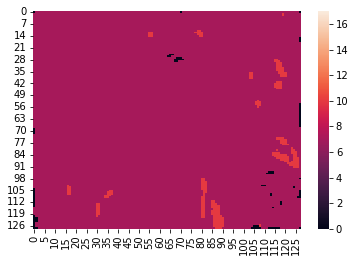

In [59]:
sns.heatmap(pred_mask[indx_b], vmax=17)

<AxesSubplot:>

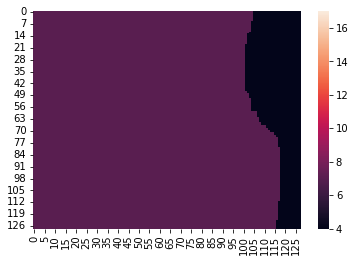

In [60]:
sns.heatmap(target[indx_b][0], vmax=17)

<AxesSubplot:>

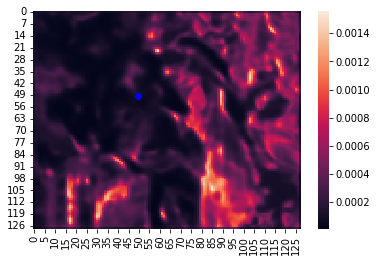

In [61]:
x, y = 50, 50
plt.plot(x,y,'bo') 
sns.heatmap(pred_attention_pam[indx_b][x, y] * net.pam_module.gamma.detach().cpu())

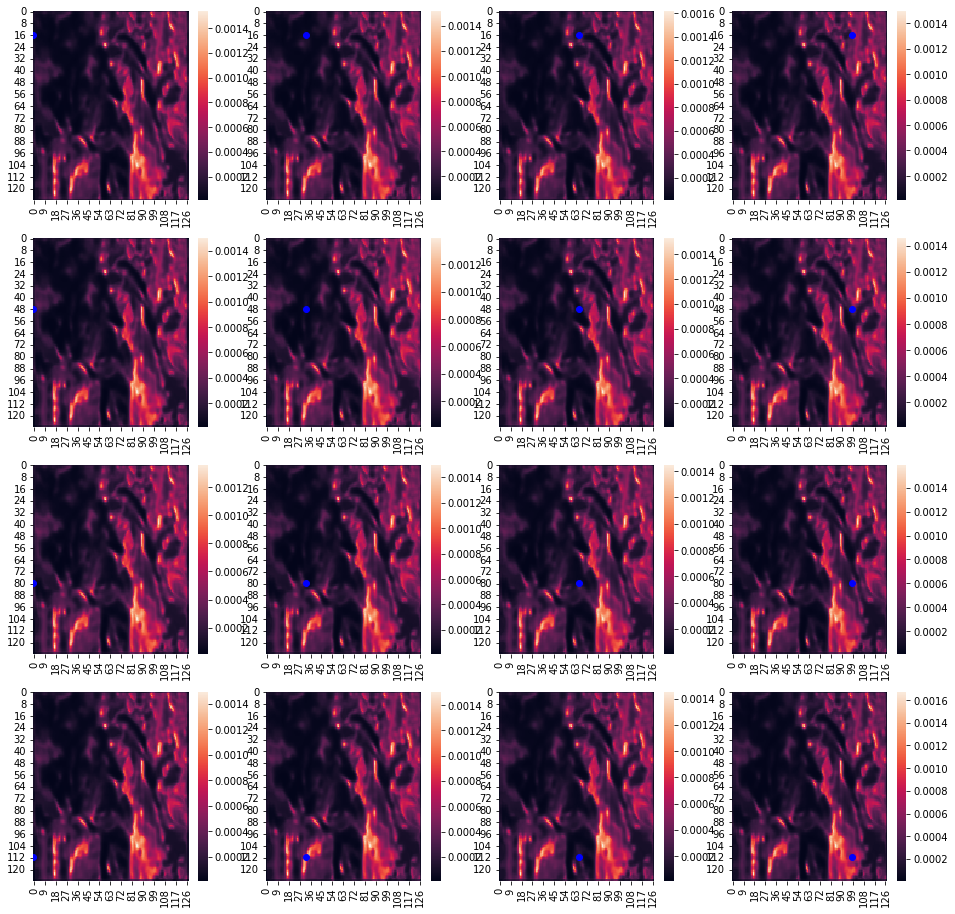

In [62]:
count_x = 4
count_y = 4

size_x = 128 // count_x
size_y = 128 // count_y
y_i, x_i = 0, 0
mid_x, mid_y = size_x // 2, size_y // 2

fig = plt.figure(figsize=(16, 16))

for i in range(1, count_x * count_y + 1):
    fig.add_subplot(count_x, count_y, i)
    if x_i == count_x:
        x_i = 0
        y_i += 1
    x, y = x_i + x_i * size_x, mid_y + y_i * size_y
    plt.plot(x,y,'bo') 
    sns.heatmap(pred_attention_pam[indx_b][x, y] * net.pam_module.gamma.detach().cpu())
    x_i += 1

<AxesSubplot:>

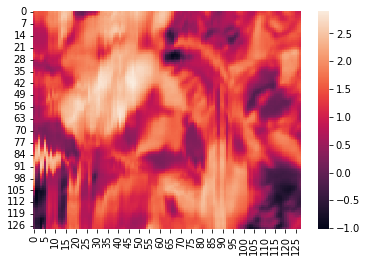

In [63]:
sns.heatmap(in_data_x_tensor[indx_b][0])

<AxesSubplot:>

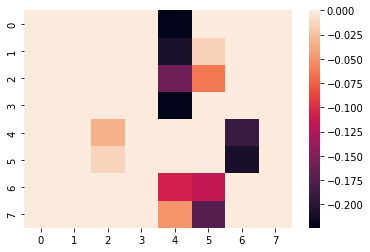

In [64]:
plt.plot(x,y,'bo') 
sns.heatmap(pred_attention_cam[indx_b] * net.cam_module.gamma.detach().cpu())

In [ ]:
sns.heatmap(target_list[indx], vmax=17)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(
    np.asarray(target_list).reshape(-1),
    np.asarray(preds_list).reshape(-1), 
    average='macro'
)

In [ ]:
f1_score(
    np.asarray(target_list).reshape(-1),
    np.asarray(preds_list).reshape(-1), 
    average='weighted'
)

In [ ]:
f1_score(
    np.asarray(target_list).reshape(-1),
    np.asarray(preds_list).reshape(-1), 
    average=None
).mean()